In [67]:
import pandas as pd
import glob
from datetime import datetime 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import skew
import math
import re
from collections import deque
import missingno
plt.style.use('ggplot')

# Load Dataset

In [68]:
train = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")

In [69]:
df = pd.concat([train,test]).reset_index(drop=True)

In [70]:
df

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,1,3,0,0,0,2,3,0,Normal,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,13,24,0,0,0,24,24,0,Generic,1
257669,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,2,0,0,0,1,1,0,Shellcode,1
257670,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,13,0,0,0,3,12,0,Generic,1
257671,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,14,30,0,0,0,30,30,0,Generic,1


In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257673 entries, 0 to 257672
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  si

# About Dataset

| No. | Name                | Type     | Description                                                                               |
|-----|---------------------|----------|-------------------------------------------------------------------------------------------|
| 1   | srcip               | nominal  | Source IP address                                                                         |
| 2   | sport               | integer  | Source port number                                                                        |
| 3   | dstip               | nominal  | Destination IP address                                                                    |
| 4   | dsport              | integer  | Destination port number                                                                   |
| 5   | proto               | nominal  | Transaction protocol                                                                     |
| 6   | state               | nominal  | Indicates the state and its dependent protocol, e.g., ACC, CLO, CON, ECO, ECR, FIN, INT, MAS, PAR,...|
| 7   | dur                 | Float    | Record total duration                                                                    |
| 8   | sbytes              | integer  | Source to destination transaction bytes                                                   |
| 9   | dbytes              | integer  | Destination to source transaction bytes                                                   |
| 10  | sttl                | integer  | Source to destination time to live value                                                  |
| 11  | dttl                | integer  | Destination to source time to live value                                                  |
| 12  | sloss               | integer  | Source packets retransmitted or dropped                                                  |
| 13  | dloss               | integer  | Destination packets retransmitted or dropped                                             |
| 14  | service             | nominal  | http, ftp, smtp, ssh, dns, ftp-data, irc and (-) if not much used service                 |
| 15  | Sload               | Float    | Source bits per second                                                                   |
| 16  | Dload               | Float    | Destination bits per second                                                              |
| 17  | Spkts               | integer  | Source to destination packet count                                                       |
| 18  | Dpkts               | integer  | Destination to source packet count                                                       |
| 19  | swin                | integer  | Source TCP window advertisement value                                                    |
| 20  | dwin                | integer  | Destination TCP window advertisement value                                               |
| 21  | stcpb               | integer  | Source TCP base sequence number                                                           |
| 22  | dtcpb               | integer  | Destination TCP base sequence number                                                      |
| 23  | smeansz             | integer  | Mean of the flow packet size transmitted by the source                                    |
| 24  | dmeansz             | integer  | Mean of the flow packet size transmitted by the destination                               |
| 25  | trans_depth         | integer  | Represents the pipelined depth into the connection of http request/response transaction   |
| 26  | res_bdy_len         | integer  | Actual uncompressed content size of the data transferred from the server’s http service   |
| 27  | Sjit                | Float    | Source jitter (mSec)                                                                     |
| 28  | Djit                | Float    | Destination jitter (mSec)                                                                |
| 29  | Stime               | Timestamp| Record start time                                                                        |
| 30  | Ltime               | Timestamp| Record last time                                                                         |
| 31  | Sintpkt             | Float    | Source interpacket arrival time (mSec)                                                   |
| 32  | Dintpkt             | Float    | Destination interpacket arrival time (mSec)                                              |
| 33  | tcprtt              | Float    | TCP connection setup round-trip time, the sum of ‘synack’ and ‘ackdat’                    |
| 34  | synack              | Float    | TCP connection setup time, the time between the SYN and the SYN_ACK packets                |
| 35  | ackdat              | Float    | TCP connection setup time, the time between the SYN_ACK and the ACK packets                |
| 36  | is_sm_ips_ports     | Binary   | If source (1) and destination (3) IP addresses equal and port numbers (2)(4) equal then, this variable...|
| 37  | ct_state_ttl        | Integer  | No. for each state (6) according to specific range of values for source/destination time to live (10...|
| 38  | ct_flw_http_mthd    | Integer  | No. of flows that has methods such as Get and Post in http service                         |
| 39  | is_ftp_login        | Binary   | If the FTP session is accessed by user and password then 1 else 0                            |
| 40  | ct_ftp_cmd          | integer  | No of flows that has a command in FTP session                                             |
| 41  | ct_srv_src          | integer  | No. of connections that contain the same service (14) and source address (1) in 100 connections...|
| 42  | ct_srv_dst          | integer  | No. of connections that contain the same service (14) and destination address (3) in 100 connections...|
| 43  | ct_dst_ltm          | integer  | No. of connections of the same destination address (3) in 100 connections according to the last time...|
| 44  | ct_src_ltm          | integer  | No. of connections of the same source address (1) in 100 connections according to the last time (26)...
| 45  | ct_src_dport_ltm    | integer  | No of connections of the same source address (1) and the destination port (4) in 100 connections acc...|
| 46  | ct_dst_sport_ltm   | integer  | No of connections of the same destination address (3) and the source port (2) in 100 connections acc...|
| 47  | ct_dst_src_ltm     | integer  | No of connections of the same source (1) and the destination (3) address in 100 connections according...|
| 48  | attack_cat          | nominal  | The name of each attack category. In this data set, nine categories e.g. Fuzzers, Analysis, Backdoo...|
| 49  | Label               | binary   | 0 for normal and 1 for attack records                                                    |


# EDA

In [72]:
plt.style.use('fivethirtyeight')

## Check Data Balance

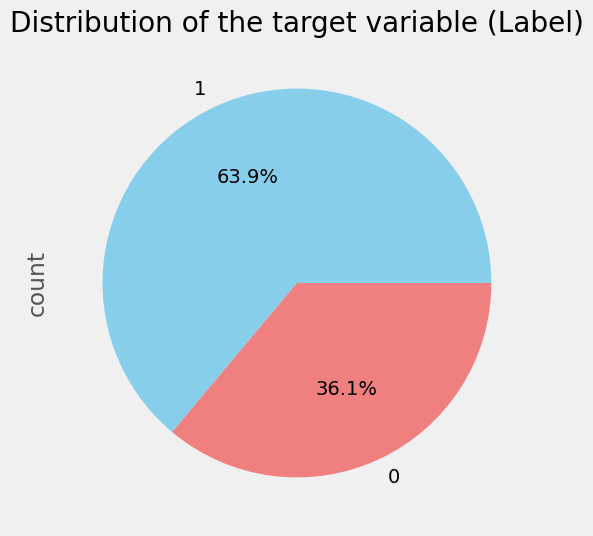

In [73]:
label_distribution = df['label'].value_counts()
plt.figure(figsize=(6, 6))
label_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Distribution of the target variable (Label)')
plt.show()

# Drop label to EDA

In [74]:
dfEDA = df.drop(['label'],axis=1)

In [75]:
dfEDA

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat
0,1,0.000011,udp,-,INT,2,0,496,0,90909.090200,...,1,1,2,0,0,0,1,2,0,Normal
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.000300,...,1,1,2,0,0,0,1,2,0,Normal
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.005100,...,1,1,3,0,0,0,1,3,0,Normal
3,4,0.000006,udp,-,INT,2,0,900,0,166666.660800,...,2,1,3,0,0,0,2,3,0,Normal
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.002500,...,2,1,3,0,0,0,2,3,0,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257668,175337,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,24,13,24,0,0,0,24,24,0,Generic
257669,175338,0.505762,tcp,-,FIN,10,8,620,354,33.612649,...,1,1,2,0,0,0,1,1,0,Shellcode
257670,175339,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,3,3,13,0,0,0,3,12,0,Generic
257671,175340,0.000009,udp,dns,INT,2,0,114,0,111111.107200,...,30,14,30,0,0,0,30,30,0,Generic


## Analyze the Distribution of Data Fields

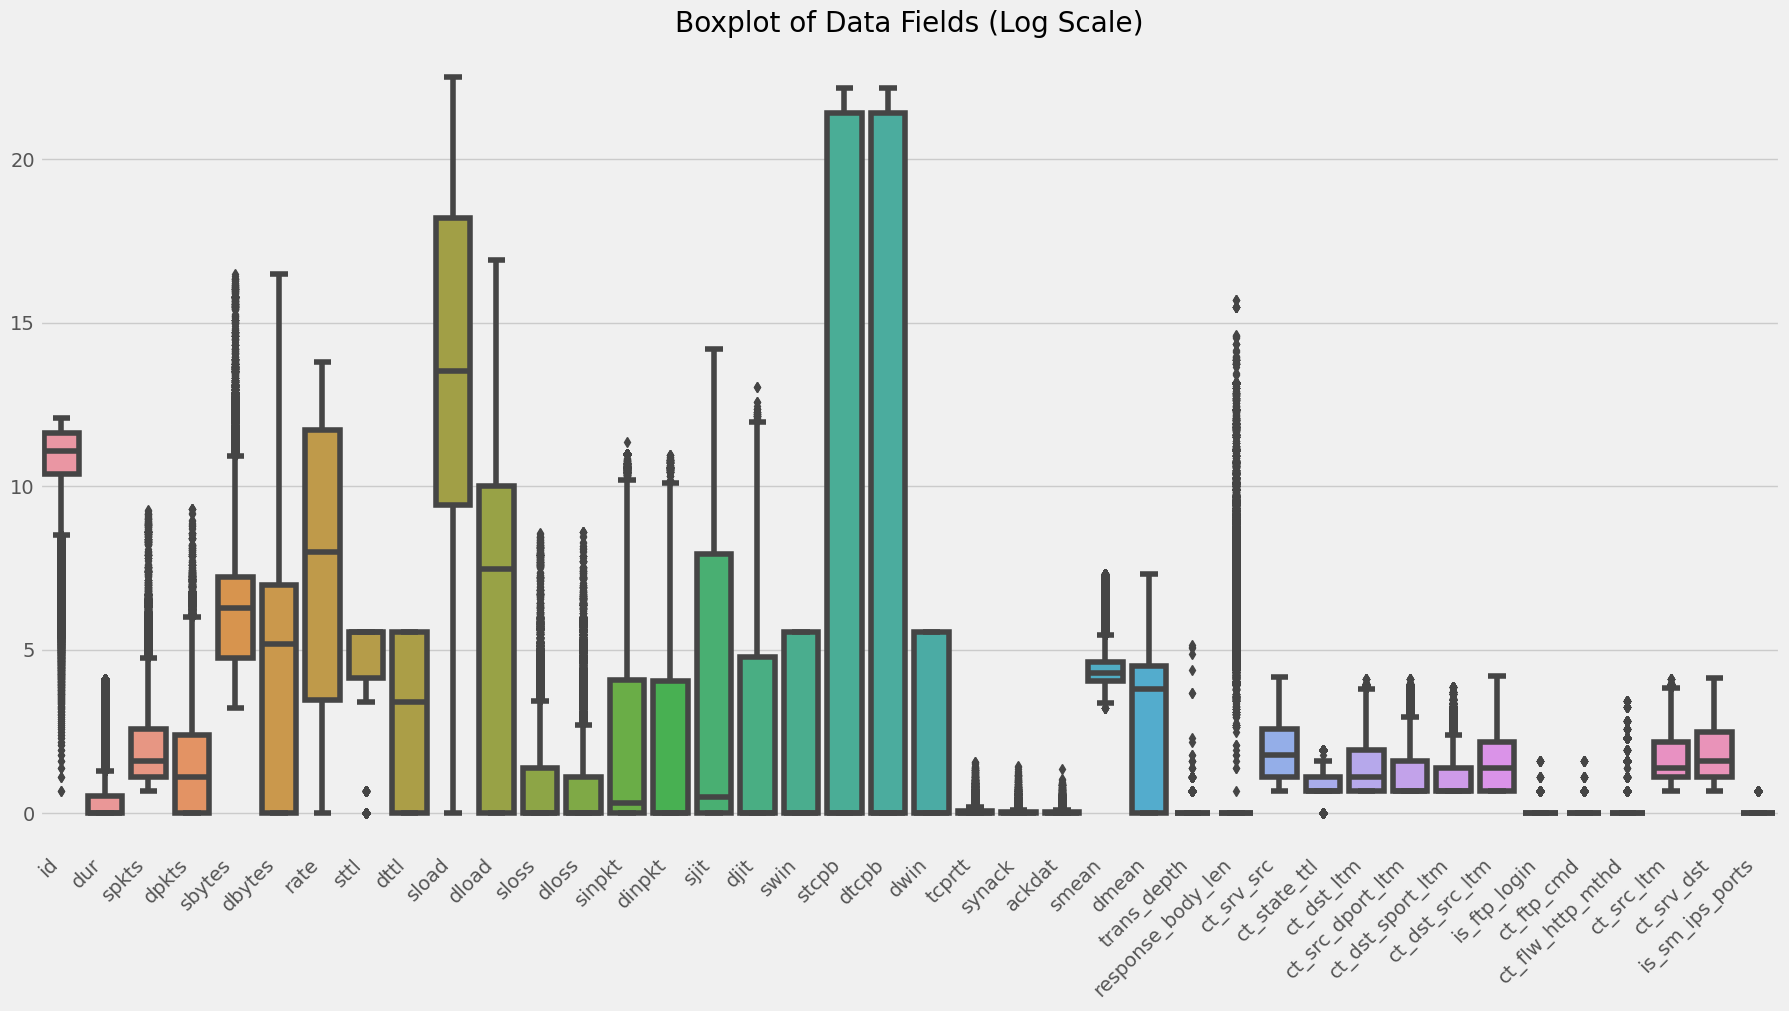

In [76]:
numeric_columns = dfEDA.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(20, 10))
ax = sns.boxplot(data=np.log1p(dfEDA[numeric_columns]))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Boxplot of Data Fields (Log Scale)')
plt.show()

- Unusual Network Activity: There may be unusual network activity or network attacks, causing some traffic to have unusual packet numbers, data amounts, or durations.

- Large Transactions: Transactions or connections that can take long periods of time or transfer large amounts of data, creating outliers.

- Error Feed: If the data provided from the source is incorrect or contains errors, it may contain unrealistic values, leading to the occurrence of exceptions.

- Cyber Attacks: Cyber attacks can create unusual behavior in data, such as transmitting large amounts of packets or performing unusual transactions.

- Measurement Bias: If the measurement process is inaccurate or has errors, it can lead to outliers in the data.

- System Problems: Problems in the system or network equipment can also cause outliers, due to the inability to accurately measure or record data.

## Correlation

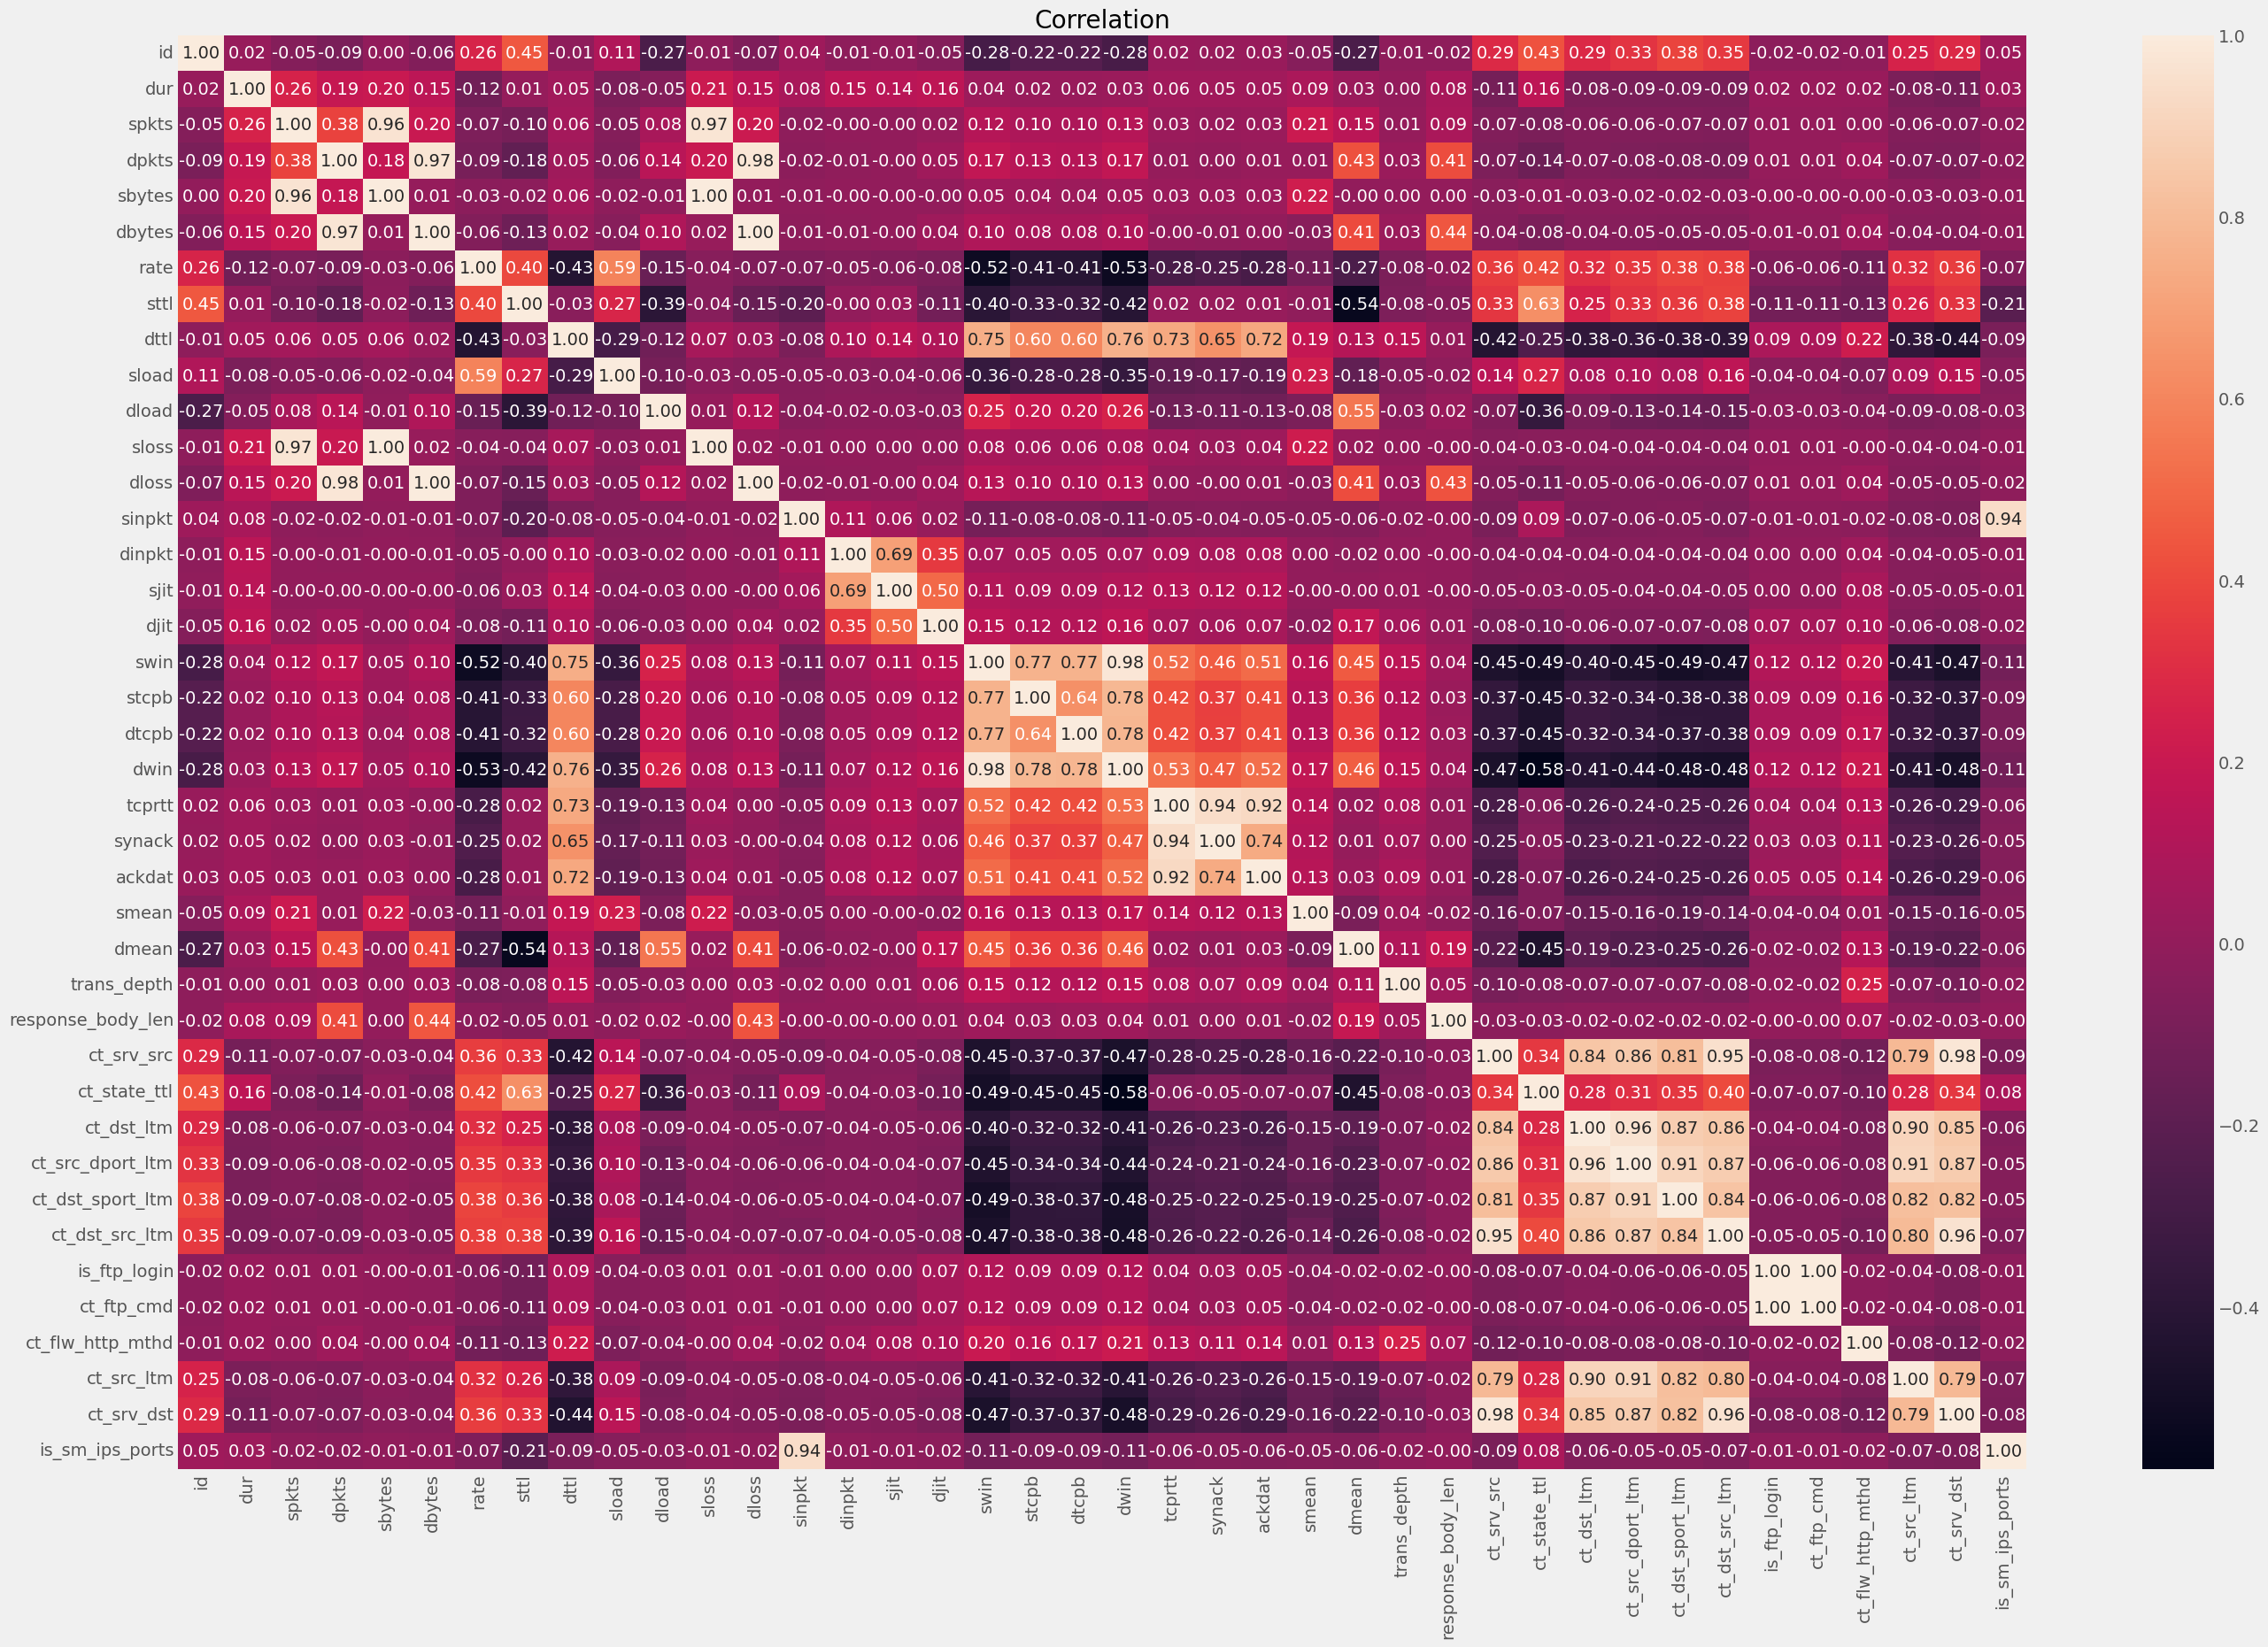

In [77]:
correlation_matrix = dfEDA[numeric_columns].corr()
plt.figure(figsize=(30, 20))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f")
plt.title('Correlation')
plt.show()

Variables with Strong Positive Relationships:
- spkts and sbytes have a strong positive relationship with dpkts and dbytes (correlation > 0.95). This may indicate a high correlation between the number of packets and the number of bytes in the packets.

- ct_srv_src has a strong positive relationship with ct_src_ltm, ct_srv_dst, and some other variables.

Variables with Strong Negative Relationships:
- dttl has a strong negative relationship with sttl (correlation < -0.45). This suggests a contrasting relationship between the Time to Live of the source and destination.

- dload has a strong negative relationship with sload (correlation < -0.35). This indicates an opposing relationship between download and upload loads.

Variables with No Significant Relationships:
- Some variables have a correlation very close to 0, for example: id, dwin, trans_depth.

General Relationships:
- Variables related to the number of packets and bytes tend to have a high correlation with each other.

- Time-related variables (e.g., dur, tcprtt, synack, ackdat) do not show strong relationships with other variables.



Identifying Strong Relationships Between Variable Pairs:
Positive Relationships:

spkts and sbytes:

- Strong positive correlation (correlation > 0.95).
- Indicates a close relationship between the number of packets (spkts) and the number of bytes (sbytes).

ct_srv_src and ct_src_ltm:
- Strong positive correlation (correlation = 0.822486).
- Suggests a significant relationship between the number of connections with the same service and source address (ct_srv_src) and the number of connections with the same source address (ct_src_ltm).

ct_srv_src and ct_srv_dst:
- Strong positive correlation.
- Indicates a close relationship between the number of connections with the same service and source address (ct_srv_src) and the number of connections with the same service and destination address (ct_srv_dst).

Negative Relationships:
dttl and sttl:
- Strong negative correlation (correlation < -0.45).
- Suggests an inverse relationship between the Time to Live of the destination (dttl) and the Time to Live of the source (sttl).

dload and sload:
- Strong negative correlation (correlation < -0.35).
- Indicates an opposing relationship between download load (dload) and upload load (sload).

## Analysis of Attack Types

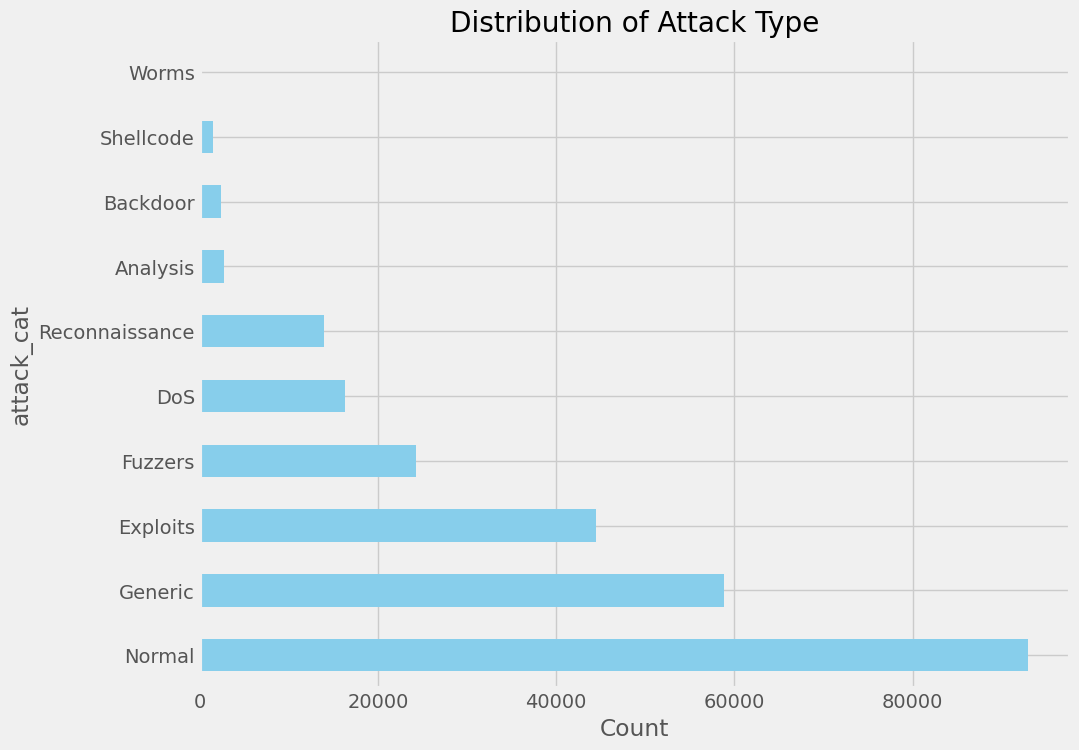

In [78]:
attack_cat_distribution = dfEDA['attack_cat'].value_counts()
plt.figure(figsize=(10, 8))
attack_cat_distribution.plot(kind='barh', color='skyblue')
plt.title('Distribution of Attack Type')
plt.xlabel('Count')
plt.show()

- Common Attack Types:
“Normal” dominates the data, suggesting that most communications in the network are legitimate and attack-free.

- Dominant Attack Type:
"Generic", "Exploits", and "Fuzzers" make up a large number of attack types. This may imply that the system needs to pay special attention to these types of attacks, and security measures can be implemented to prevent them.
- Critical Attack Type:
"Worms" are the least numerous, but they can often cause great damage due to their ability to spread quickly. Although small in number, special attention should be paid to this type of attack because of its highly dangerous nature.
- Specific Classification:
Classifications such as "DoS", "Reconnaissance", "Analysis", "Backdoor", and "Shellcode" are also represented in the data, creating a need to detect and prevent specific types of attacks.
- The Importance of Classification:
Understanding the types of attacks and classifying them helps determine priorities and appropriate security approaches. For example, a system can focus strongly on preventing "Exploits" attacks if they account for a high proportion.

### Comparison Between Normal and Attack Data

<Figure size 1200x800 with 0 Axes>

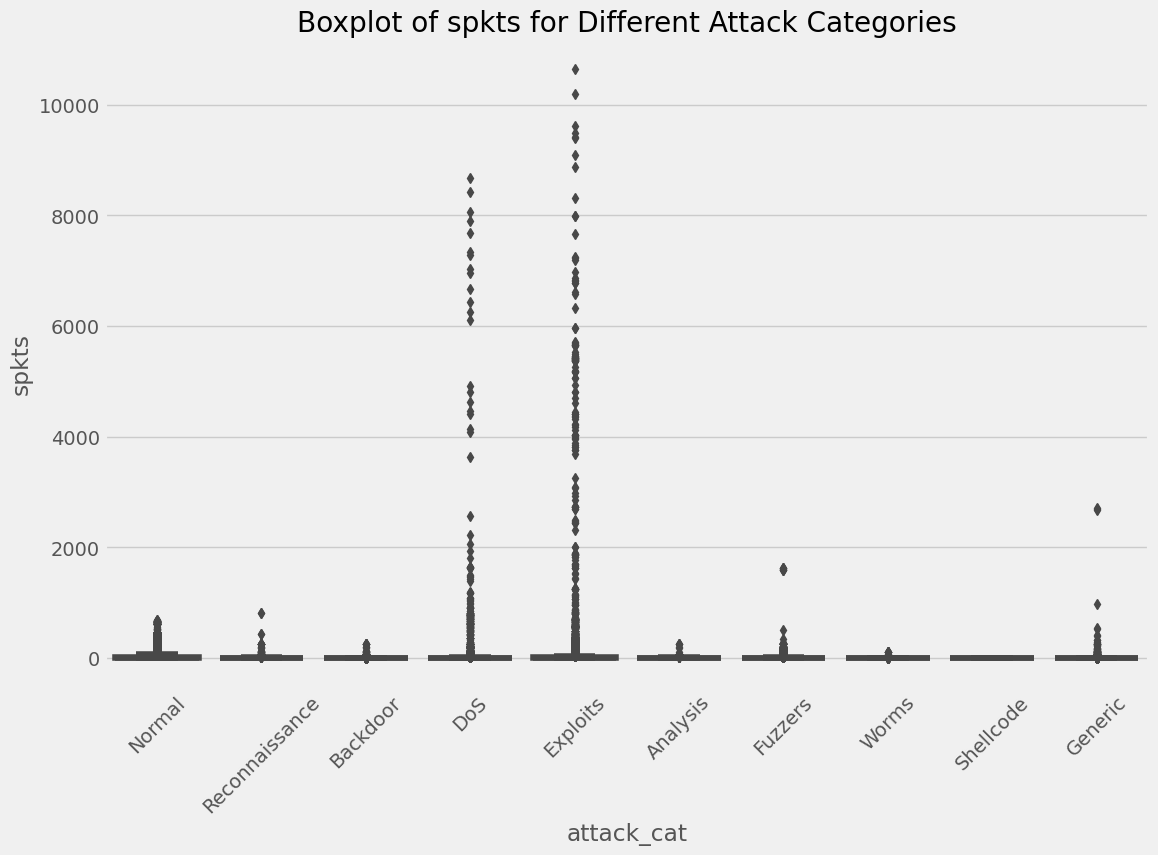

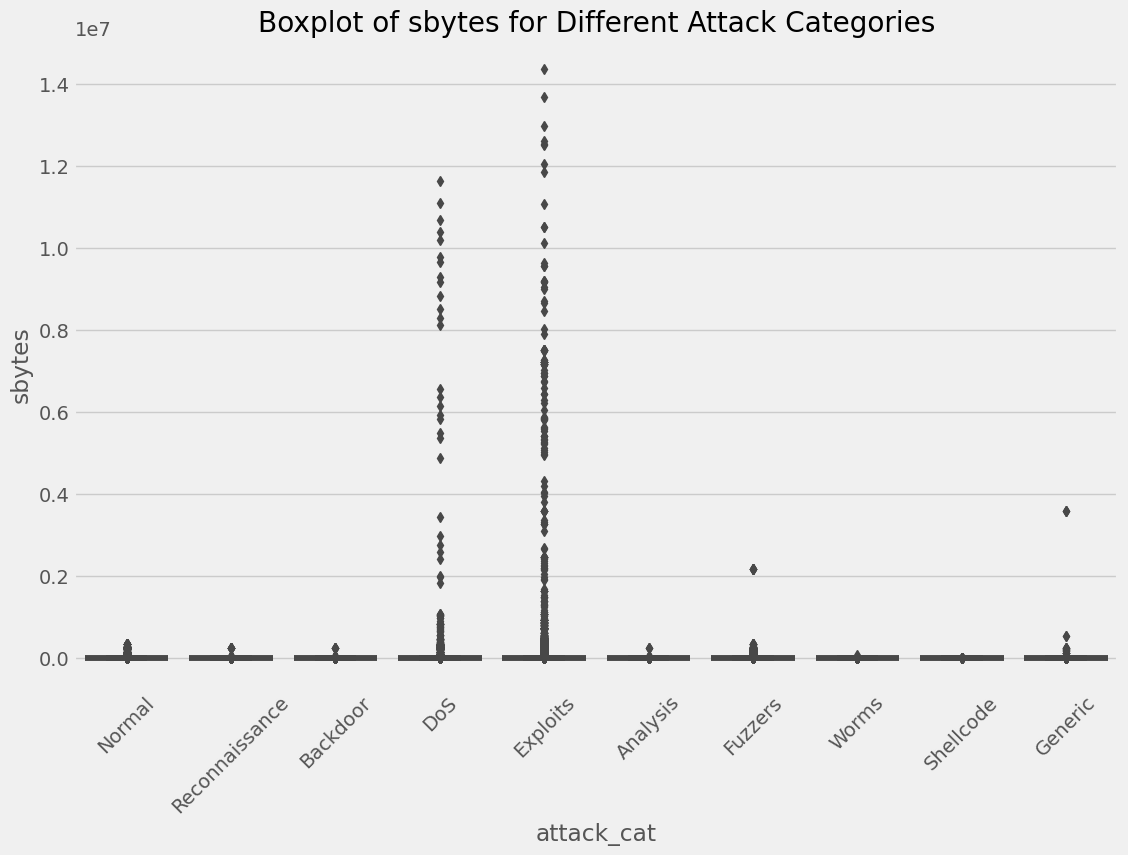

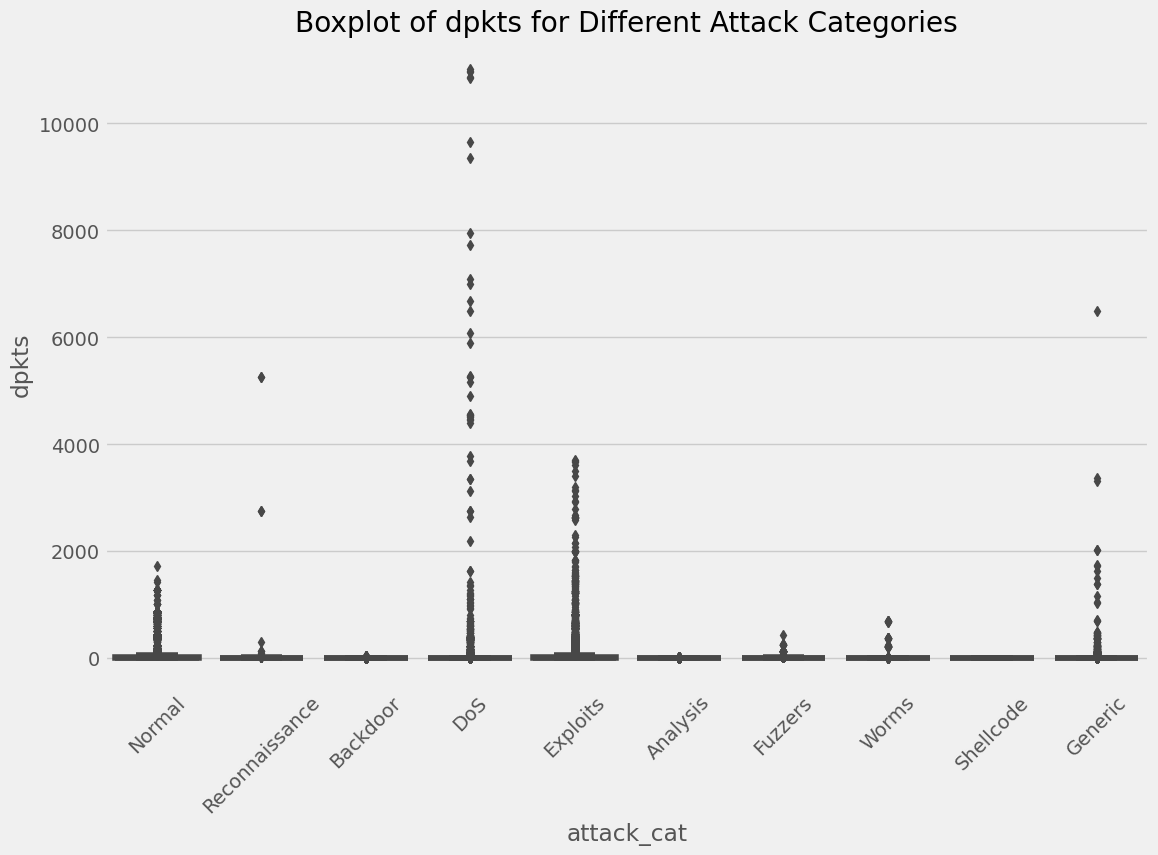

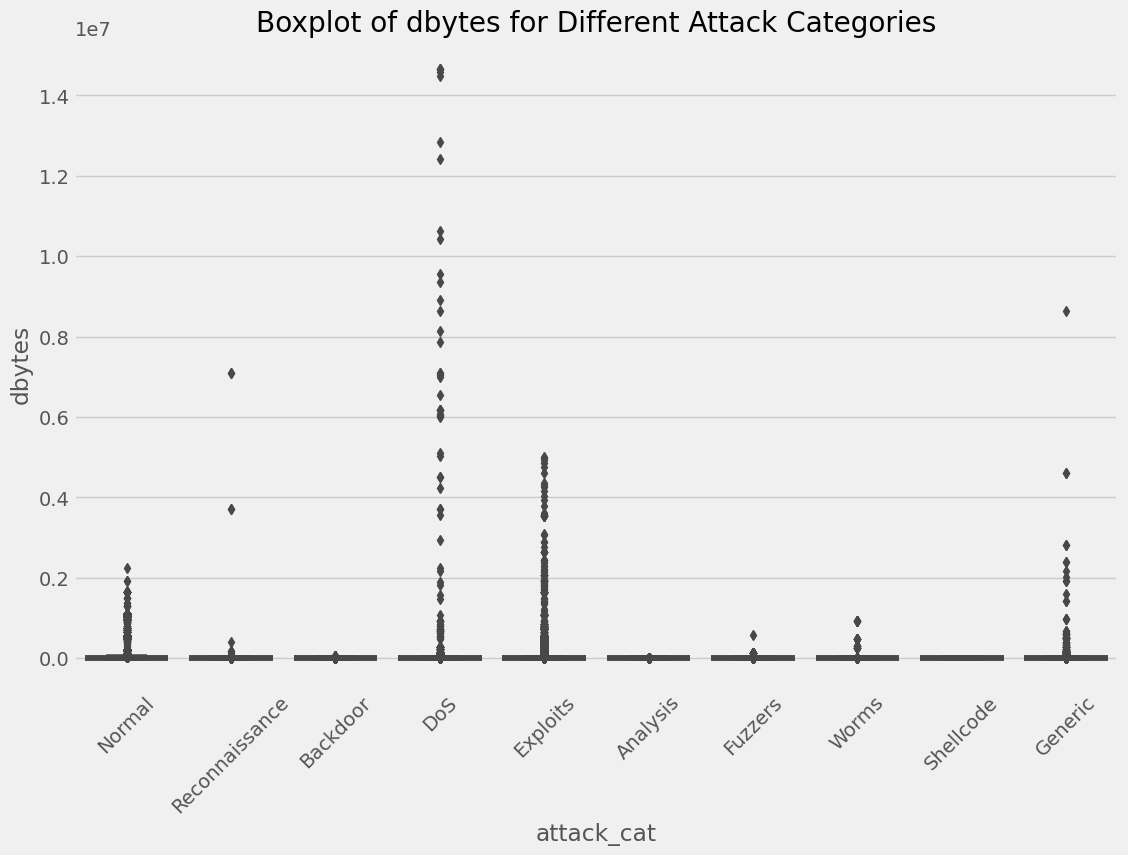

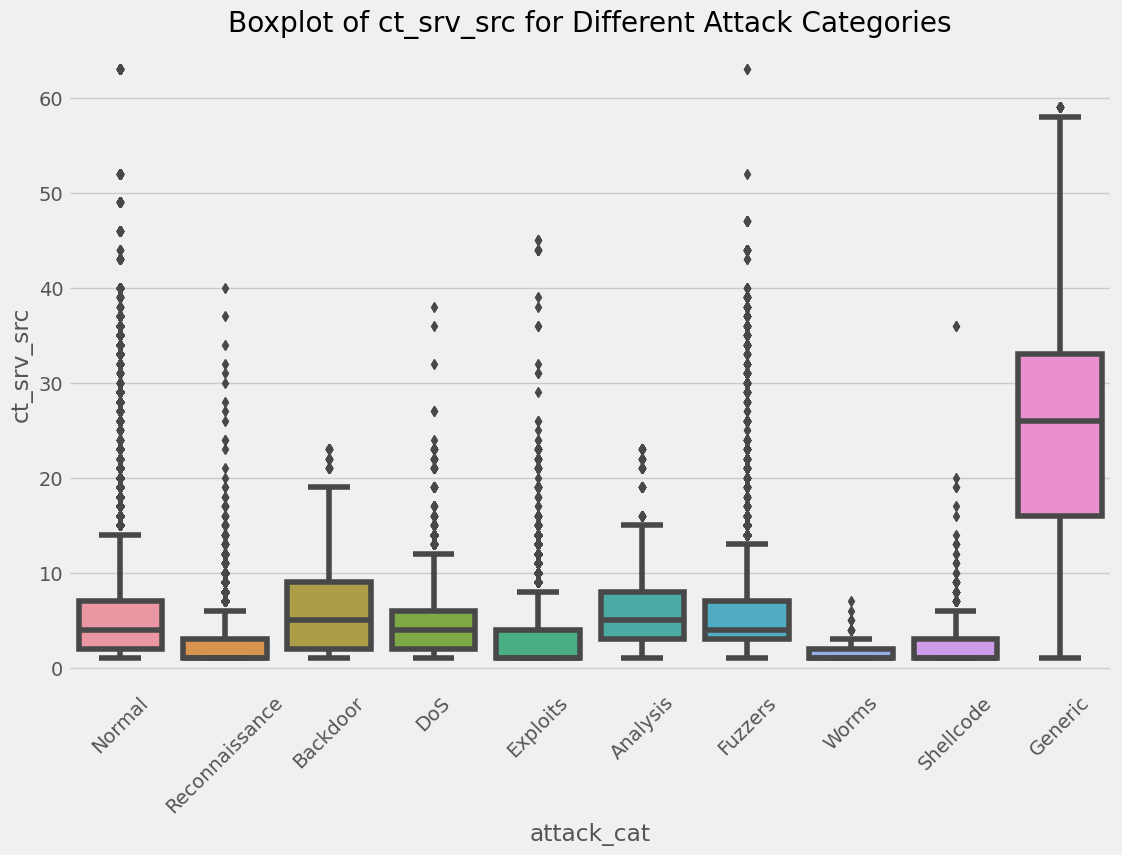

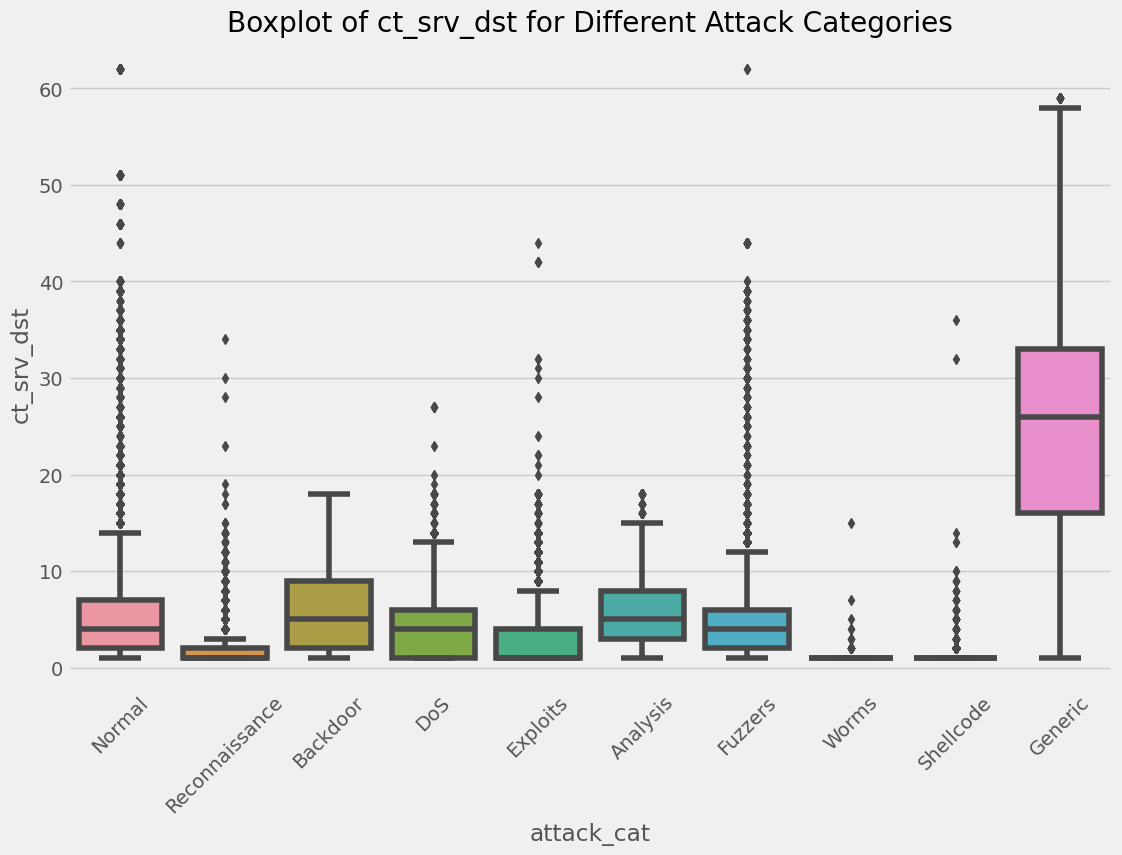

In [79]:
variables_to_analyze = ['spkts', 'sbytes', 'dpkts', 'dbytes', 'ct_srv_src', 'ct_srv_dst']

plt.figure(figsize=(12, 8))
for variable in variables_to_analyze:
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='attack_cat', y=variable, data=df)
    plt.title(f'Boxplot of {variable} for Different Attack Categories')
    plt.xticks(rotation=45)
    plt.show()


- Normal and Attacks Differ in Scale:

Normal data tends to have a larger scale compared to many types of attacks, as shown by fields such as the number of packets (spkts), number of bytes (sbytes), and the number of connections (ct_srv_src and ct_srv_dst).
- Attacks Usually Have a Smaller Scale:

Attack types such as Reconnaissance, Backdoor, and Analysis typically have lower average values across many numerical fields compared to normal data.
- Diverse Distribution of Attack Data:

Different attack types exhibit diversity in the average values and distribution of numerical fields. This highlights the distinct characteristics of each attack type.
- Significant Differences in Key Fields:

Fields such as the number of packets, number of bytes, and number of connections show substantial differences between normal and attack data.
- In summary, these numerical fields can be utilized to build intrusion detection models based on the differences in features between normal and attack data.








## Missing Values

In [80]:
df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

<Axes: >

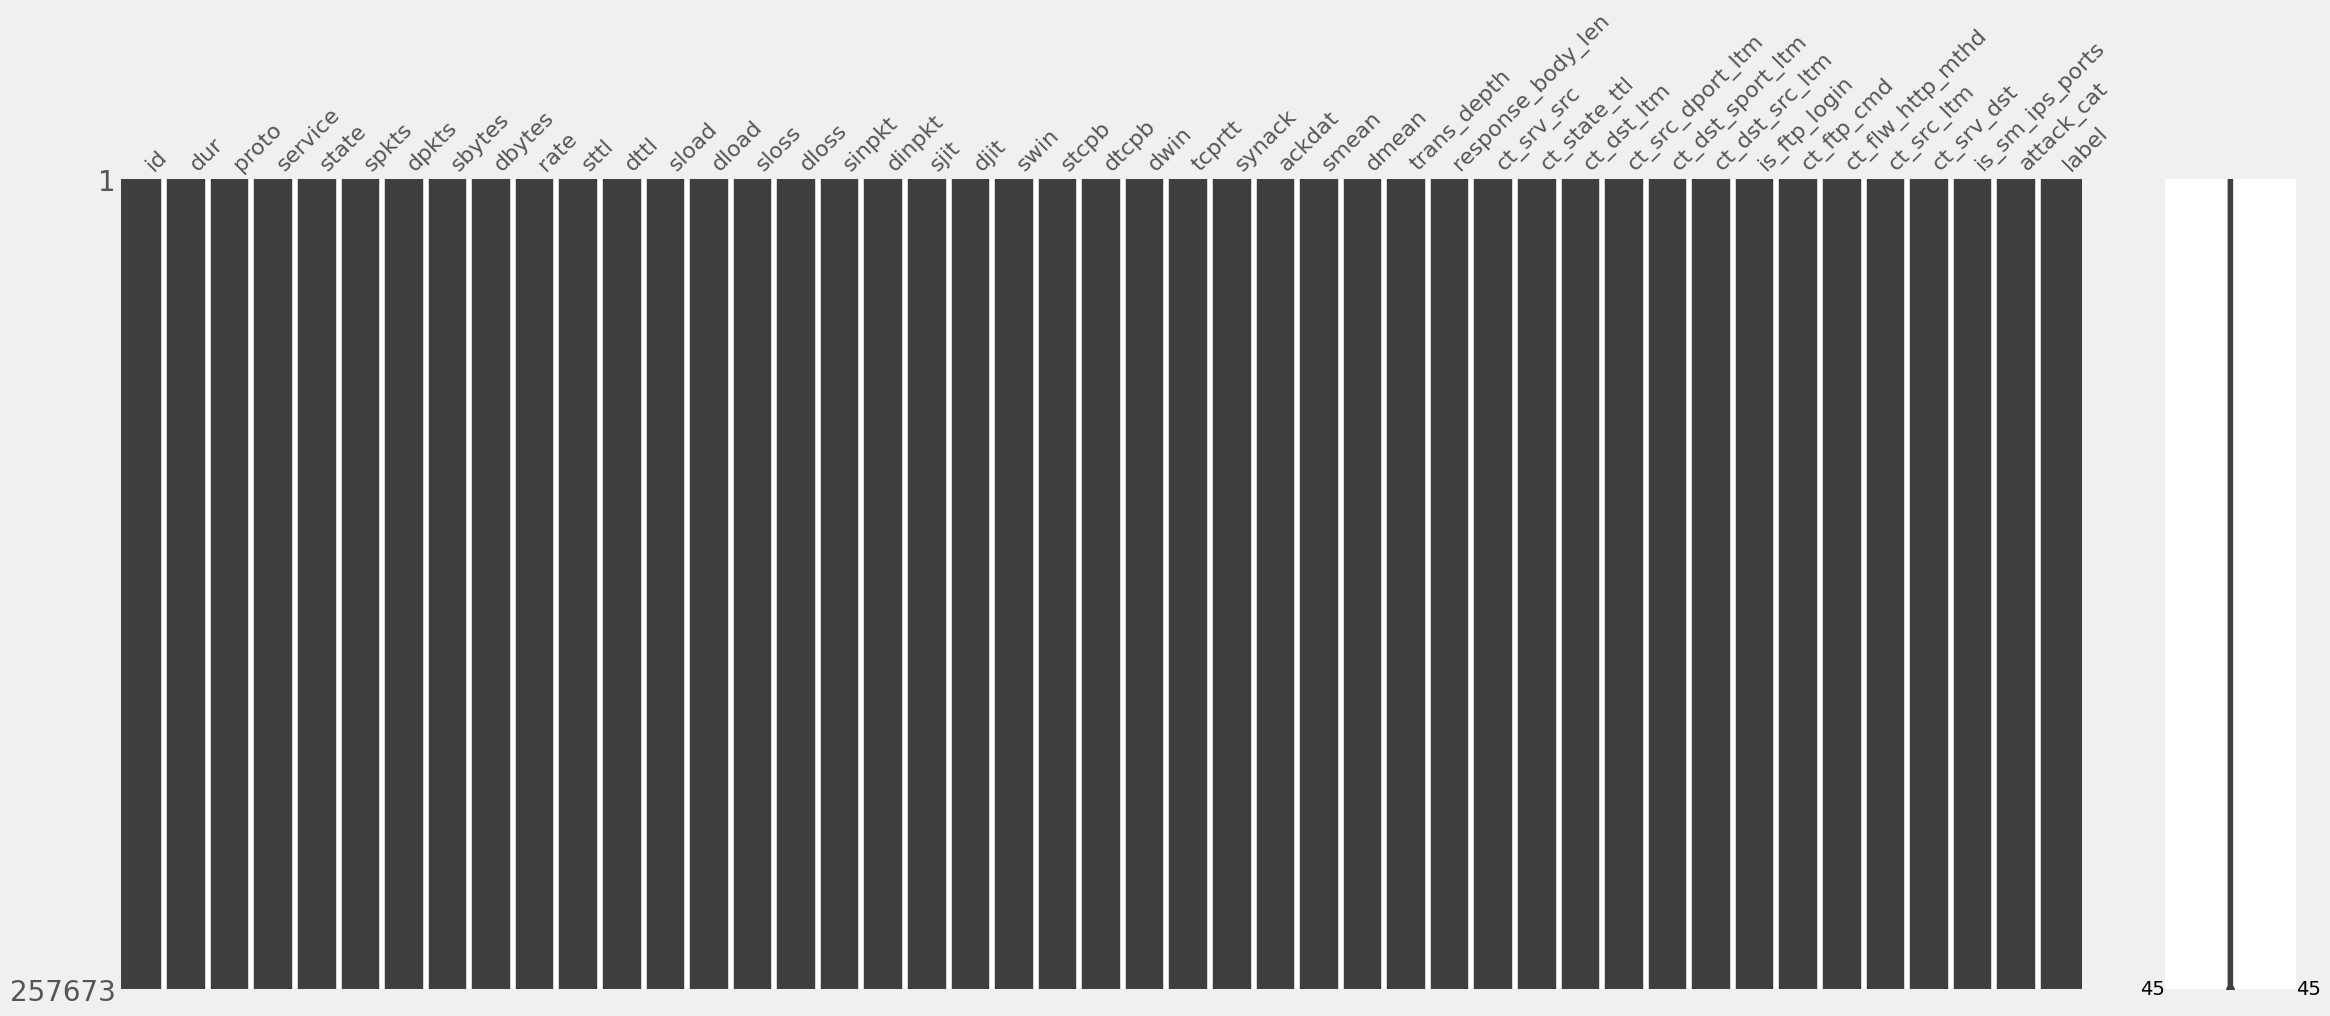

In [81]:
missingno.matrix(df)

Data is clean and there are no missing values.



In [82]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,257673.0,7.281182e+04,4.892992e+04,1.0,32210.000000,64419.000000,1.109230e+05,1.753410e+05
dur,257673.0,1.246715e+00,5.974305e+00,0.0,0.000008,0.004285,6.857770e-01,5.999999e+01
spkts,257673.0,1.977714e+01,1.359472e+02,1.0,2.000000,4.000000,1.200000e+01,1.064600e+04
dpkts,257673.0,1.851470e+01,1.119860e+02,0.0,0.000000,2.000000,1.000000e+01,1.101800e+04
sbytes,257673.0,8.572952e+03,1.737739e+05,24.0,114.000000,528.000000,1.362000e+03,1.435577e+07
dbytes,257673.0,1.438729e+04,1.461993e+05,0.0,0.000000,178.000000,1.064000e+03,1.465753e+07
rate,257673.0,9.125391e+04,1.603446e+05,0.0,30.789277,2955.664893,1.250000e+05,1.000000e+06
sttl,257673.0,1.800009e+02,1.024883e+02,0.0,62.000000,254.000000,2.540000e+02,2.550000e+02
dttl,257673.0,8.475496e+01,1.127621e+02,0.0,0.000000,29.000000,2.520000e+02,2.540000e+02
sload,257673.0,7.060869e+07,1.857313e+08,0.0,12318.004880,743942.312500,8.000000e+07,5.988000e+09


## Insights and steps:
- Data is clean.
- Data still needs furthur processing in terms of One-hot-encoding for categorical data. E.g.: 'service' consists of different types, we have ftp, http, and '-' denoting (not available or None), So we will need to treat it as a missing value as we will change it from '-' to 'None' instead of dropping the whole column.
- Removing unnecessary features like 'id'.


In [83]:
df['proto'].unique() #This is definitely a categorical feature.

array(['udp', 'arp', 'tcp', 'igmp', 'ospf', 'sctp', 'gre', 'ggp', 'ip',
       'ipnip', 'st2', 'argus', 'chaos', 'egp', 'emcon', 'nvp', 'pup',
       'xnet', 'mux', 'dcn', 'hmp', 'prm', 'trunk-1', 'trunk-2',
       'xns-idp', 'leaf-1', 'leaf-2', 'irtp', 'rdp', 'netblt', 'mfe-nsp',
       'merit-inp', '3pc', 'idpr', 'ddp', 'idpr-cmtp', 'tp++', 'ipv6',
       'sdrp', 'ipv6-frag', 'ipv6-route', 'idrp', 'mhrp', 'i-nlsp', 'rvd',
       'mobile', 'narp', 'skip', 'tlsp', 'ipv6-no', 'any', 'ipv6-opts',
       'cftp', 'sat-expak', 'ippc', 'kryptolan', 'sat-mon', 'cpnx', 'wsn',
       'pvp', 'br-sat-mon', 'sun-nd', 'wb-mon', 'vmtp', 'ttp', 'vines',
       'nsfnet-igp', 'dgp', 'eigrp', 'tcf', 'sprite-rpc', 'larp', 'mtp',
       'ax.25', 'ipip', 'aes-sp3-d', 'micp', 'encap', 'pri-enc', 'gmtp',
       'ifmp', 'pnni', 'qnx', 'scps', 'cbt', 'bbn-rcc', 'igp', 'bna',
       'swipe', 'visa', 'ipcv', 'cphb', 'iso-tp4', 'wb-expak', 'sep',
       'secure-vmtp', 'xtp', 'il', 'rsvp', 'unas', 'fc', 'iso-ip',


In [84]:
df['service'].unique() #Here, we'll deal with the type of service that is '-'
df['service']= np.where(df['service'] == '-', 'None', df['service'])
print(df['service'].unique())

['None' 'http' 'ftp' 'ftp-data' 'smtp' 'pop3' 'dns' 'snmp' 'ssl' 'dhcp'
 'irc' 'radius' 'ssh']


In [85]:
df['state'].unique()

array(['INT', 'FIN', 'REQ', 'ACC', 'CON', 'RST', 'CLO', 'ECO', 'PAR',
       'URN', 'no'], dtype=object)

### Removing unnecessary features

In [86]:
df = df.drop(['id'], axis=1)

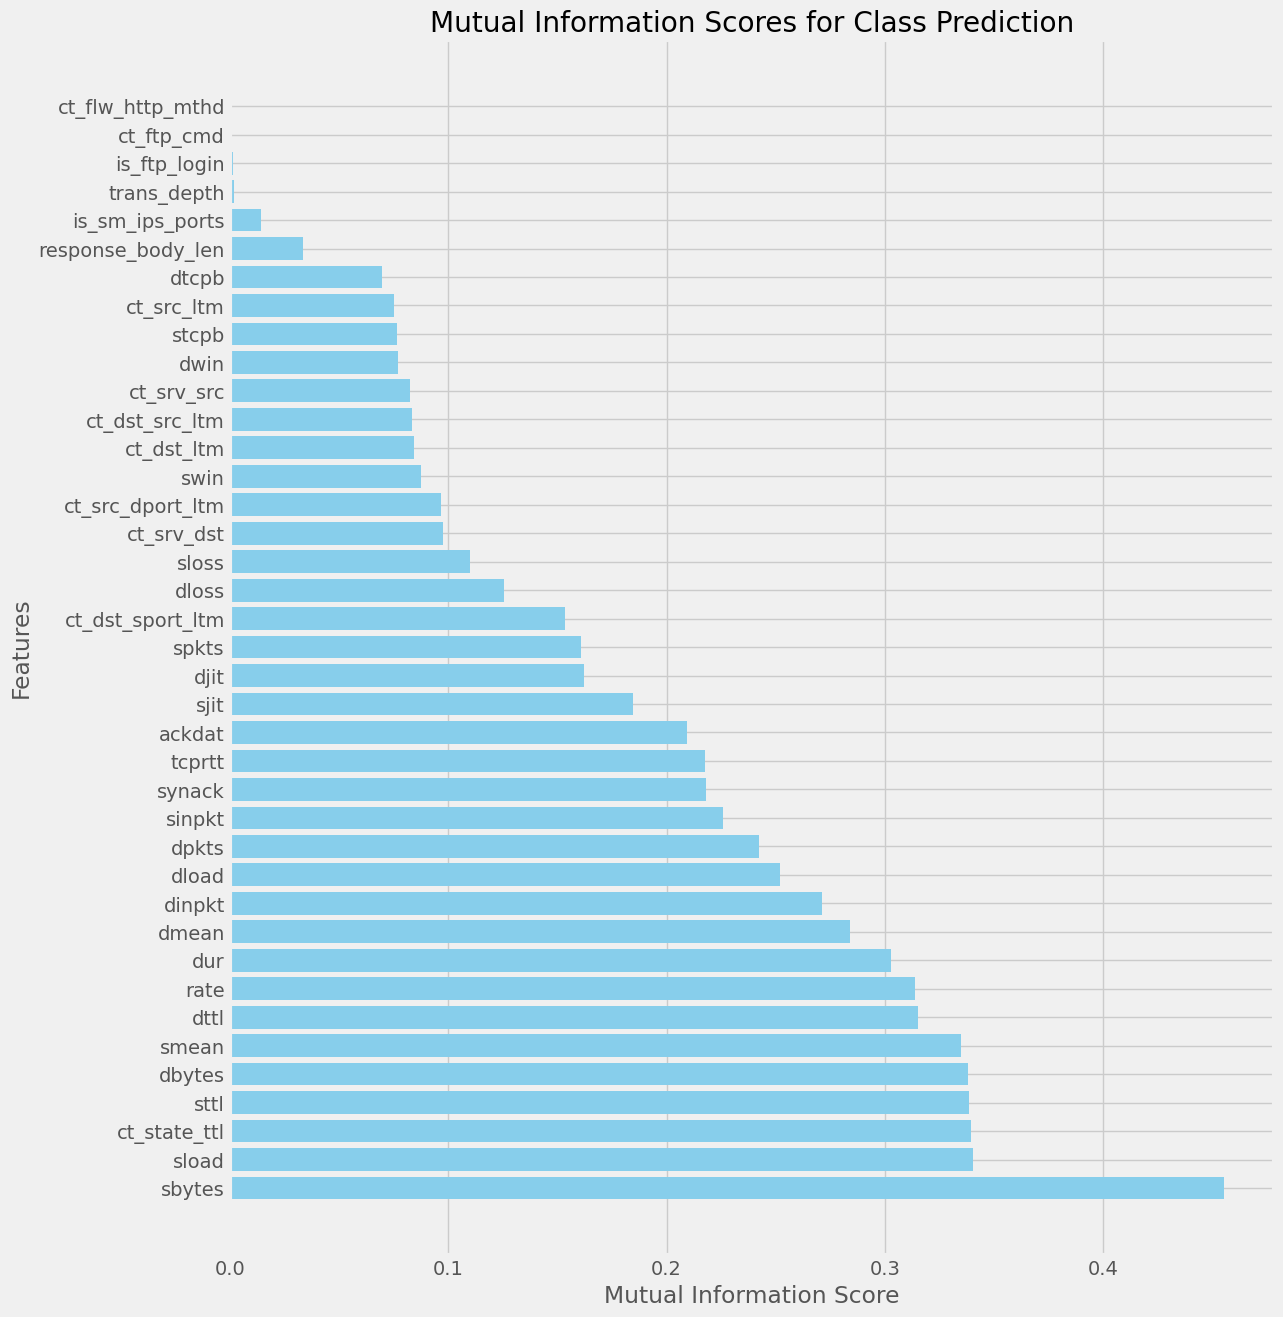

In [87]:
from sklearn.feature_selection import mutual_info_classif

X = df.select_dtypes(include=['int64', 'float64']).drop('label', axis=1)

y = df['label']

mutual_info = mutual_info_classif(X, y, random_state=42)

mi_scores = pd.Series(mutual_info, index=X.columns, name='Mutual Information Score')
mi_scores = mi_scores.sort_values(ascending=False)
plt.figure(figsize=(12, 15))
plt.barh(mi_scores.index, mi_scores, color='skyblue')
plt.title('Mutual Information Scores for Class Prediction')
plt.xlabel('Mutual Information Score')
plt.ylabel('Features')
plt.show()

### Categorical Features:
One Hot Encoding using cols_cat

In [88]:
df['attack_cat'].unique() #This is definitely a categorical feature and related to label :) so, we drop it.

array(['Normal', 'Reconnaissance', 'Backdoor', 'DoS', 'Exploits',
       'Analysis', 'Fuzzers', 'Worms', 'Shellcode', 'Generic'],
      dtype=object)

In [89]:
df = df.drop('attack_cat', axis=1)

In [90]:
"""df_encoded = pd.get_dummies(df, columns=['attack_cat'], prefix='attack_cat', dtype=int)
"""

"df_encoded = pd.get_dummies(df, columns=['attack_cat'], prefix='attack_cat', dtype=int)\n"

In [91]:
object_columns = df.select_dtypes(include=['object']).columns
object_columns

Index(['proto', 'service', 'state'], dtype='object')

In [92]:
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

shuffled_df = shuffle(df)

label_encoder = LabelEncoder()

shuffled_df['proto'] = label_encoder.fit_transform(shuffled_df['proto'])
shuffled_df['service'] = label_encoder.fit_transform(shuffled_df['service'])
shuffled_df['state'] = label_encoder.fit_transform(shuffled_df['state'])

In [93]:
shuffled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 240308 to 254980
Data columns (total 43 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   dur                257673 non-null  float64
 1   proto              257673 non-null  int64  
 2   service            257673 non-null  int64  
 3   state              257673 non-null  int64  
 4   spkts              257673 non-null  int64  
 5   dpkts              257673 non-null  int64  
 6   sbytes             257673 non-null  int64  
 7   dbytes             257673 non-null  int64  
 8   rate               257673 non-null  float64
 9   sttl               257673 non-null  int64  
 10  dttl               257673 non-null  int64  
 11  sload              257673 non-null  float64
 12  dload              257673 non-null  float64
 13  sloss              257673 non-null  int64  
 14  dloss              257673 non-null  int64  
 15  sinpkt             257673 non-null  float64
 16  di

# Train and Test set splitting

In [94]:
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = shuffled_df.drop(['label'], axis=1)  # Drop the target variable
y = shuffled_df['label']

# Split the data into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Print the shapes of the resulting sets
print("Training set shapes:", X_train.shape, y_train.shape)
print("Test set shapes:", X_test.shape, y_test.shape)


Training set shapes: (180371, 42) (180371,)
Test set shapes: (77302, 42) (77302,)


In [95]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, RobustScaler, Normalizer
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm_notebook as tqdm
import time

In [96]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import time

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from keras import metrics
!pip install keras-metrics #It doesn't come with Google Colab
import keras_metrics as km #when compiling
import keras
import numpy as np
from numpy import array

# Modelling

In [102]:
from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [116]:
import joblib
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM

# Define LSTM training function
def train_lstm(X_train, y_train, epochs=200, batch_size=2000):
    model = Sequential()
    model.add(LSTM(20, return_sequences=True, input_shape=(1, X_train.shape[1])))
    model.add(LSTM(20, return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))  # For binary classification
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', f1_m, precision_m, recall_m])

    # Encode binary labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_train_encoded = y_train_encoded.reshape(-1, 1, 1)  # Reshape labels to match the shape of predictions

    X_train_array = np.array(X_train)
    X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], 1, X_train_array.shape[1])

    # Train the model
    model.fit(X_train_reshaped, y_train_encoded, epochs=epochs, batch_size=batch_size, verbose=2)
    return model

# Define LSTM evaluation function
def evaluate_lstm(model, X_test, y_test):
    scaler = MinMaxScaler()
    X_test_array = np.array(X_test)
    X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], 1, X_test_array.shape[1])

    y_test_array = np.array(y_test)
    y_test_reshaped = y_test_array.reshape(-1, 1, 1)

    loss, accuracy, f1s, precision, recall = model.evaluate(X_test_reshaped, y_test_reshaped)

    return accuracy, loss, f1s, precision, recall

# Save the model
def save_model(model, model_name):
    model.save(f'{model_name}.h5')

# Load the model
def load_model(model_name):
    model = load_model(f'{model_name}.h5')
    return model

# Train and evaluate function for LSTM
def train_and_evaluate(X_train, X_test, y_train, y_test, normalize=False):
    if normalize:
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    model = train_lstm(X_train, y_train)
    accuracy, loss, f1s, precision, recall = evaluate_lstm(model, X_test, y_test)

    save_model(model, 'lstm_model')

    model_performance = {
        'Model': 'LSTM',
        'Accuracy': accuracy,
        'Loss': loss,
        'F1 Score': f1s,
        'Precision': precision,
        'Recall': recall
    }

    return model_performance

# Append results and create DataFrame
results_list = []

# Example: Append LSTM performance
lstm_performance_dropped_attack_cat = train_and_evaluate(X_train, X_test, y_train, y_test, normalize=True)
results_list.append(lstm_performance_dropped_attack_cat)

# Create a DataFrame from the list
results_df = pd.DataFrame(results_list)

results_df


Epoch 1/200
91/91 - 4s - loss: 0.6286 - accuracy: 0.6540 - f1_m: 0.7814 - precision_m: 0.6506 - recall_m: 0.9834 - 4s/epoch - 44ms/step
Epoch 2/200
91/91 - 0s - loss: 0.4492 - accuracy: 0.7893 - f1_m: 0.8543 - precision_m: 0.7667 - recall_m: 0.9649 - 438ms/epoch - 5ms/step
Epoch 3/200
91/91 - 0s - loss: 0.3068 - accuracy: 0.8724 - f1_m: 0.9068 - precision_m: 0.8515 - recall_m: 0.9701 - 437ms/epoch - 5ms/step
Epoch 4/200
91/91 - 0s - loss: 0.2451 - accuracy: 0.8884 - f1_m: 0.9173 - precision_m: 0.8724 - recall_m: 0.9672 - 438ms/epoch - 5ms/step
Epoch 5/200
91/91 - 0s - loss: 0.2259 - accuracy: 0.8927 - f1_m: 0.9201 - precision_m: 0.8794 - recall_m: 0.9650 - 439ms/epoch - 5ms/step
Epoch 6/200
91/91 - 0s - loss: 0.2165 - accuracy: 0.8953 - f1_m: 0.9216 - precision_m: 0.8848 - recall_m: 0.9618 - 438ms/epoch - 5ms/step
Epoch 7/200
91/91 - 0s - loss: 0.2110 - accuracy: 0.8976 - f1_m: 0.9232 - precision_m: 0.8891 - recall_m: 0.9601 - 438ms/epoch - 5ms/step
Epoch 8/200
91/91 - 0s - loss: 0.207

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


,Model,Accuracy,Loss,F1 Score,Precision,Recall
0,LSTM,0.930015,0.15223,0.944413,0.941237,0.950315


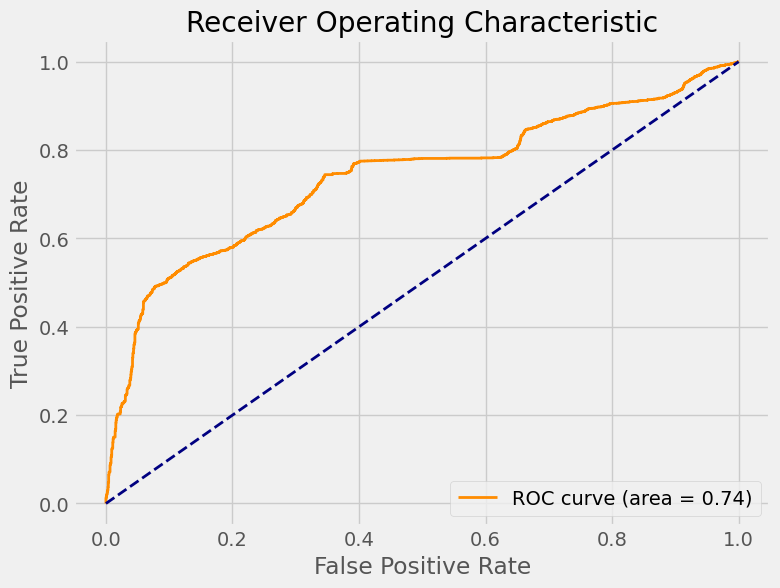

Average ROC AUC: 0.7343128659666518
Average Optimal Threshold: -7.585089404145111
Best Threshold: -11.124867888198947


In [117]:
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

# Assuming your features are stored in X and labels in y
XX = shuffled_df.drop(['label'], axis=1)
yy = shuffled_df['label']

# Train-Test Split
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
XX_train_scaled = scaler.fit_transform(XX_train)
XX_test_scaled = scaler.transform(XX_test)

# Train Beta Mixture Model
bmm = BayesianGaussianMixture(n_components=2, max_iter=100, random_state=42)
bmm.fit(XX_train_scaled[yy_train == 0])

anomaly_scores = -bmm.score_samples(XX_test_scaled)
yy_test = yy_test.reset_index(drop=True)  # Reset the index of yy_test

# Perform 10-fold cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Lists to store results for each fold
roc_auc_list = []
optimal_threshold_list = []

# Variables to store values for the best threshold
best_fpr = None
best_tpr = None
best_threshold = None
best_roc_auc = 0.0

for train_index, test_index in kf.split(XX_test_scaled, yy_test):
    X_train_fold, X_test_fold = XX_test_scaled[train_index], XX_test_scaled[test_index]
    y_train_fold, y_test_fold = yy_test[train_index], yy_test[test_index]

    anomaly_scores_fold = -bmm.score_samples(X_test_fold)

    fpr, tpr, thresholds = roc_curve(y_test_fold, anomaly_scores_fold)
    roc_auc = auc(fpr, tpr)

    # Find the threshold that maximizes the Youden's Index (sensitivity + specificity - 1)
    Youden_Index = tpr - fpr
    optimal_threshold = thresholds[np.argmax(Youden_Index)]

    roc_auc_list.append(roc_auc)
    optimal_threshold_list.append(optimal_threshold)

    # Update best threshold if the current fold has a higher ROC AUC
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_fpr = fpr
        best_tpr = tpr
        best_threshold = optimal_threshold

# Plot the ROC curve for the best fold
plt.figure(figsize=(8, 6))
plt.plot(best_fpr, best_tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(best_roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Find the average ROC AUC across all folds
average_roc_auc = np.mean(roc_auc_list)
print(f'Average ROC AUC: {average_roc_auc}')

# Find the average optimal threshold across all folds
average_optimal_threshold = np.mean(optimal_threshold_list)
print(f'Average Optimal Threshold: {average_optimal_threshold}')

# Print the best threshold
print(f'Best Threshold: {best_threshold}')



In [118]:
# Default threshold
default_threshold = 0.5
default_predictions = (anomaly_scores > default_threshold).astype(int)
default_accuracy = accuracy_score(yy_test, default_predictions)
default_precision = precision_score(yy_test, default_predictions)
default_recall = recall_score(yy_test, default_predictions)
default_f1 = f1_score(yy_test, default_predictions)

#Avg optimal
average_optimal_predictions = (anomaly_scores > average_optimal_threshold).astype(int)
average_optimal_accuracy = accuracy_score(yy_test, average_optimal_predictions)
average_optimal_precision = precision_score(yy_test, average_optimal_predictions)
average_optimal_recall = recall_score(yy_test, average_optimal_predictions)
average_optimal_f1 = f1_score(yy_test, average_optimal_predictions)

#Best
best_predictions = (anomaly_scores > best_threshold).astype(int)
best_accuracy = accuracy_score(yy_test, best_predictions)
best_precision = precision_score(yy_test, best_predictions)
best_recall = recall_score(yy_test, best_predictions)
best_f1 = f1_score(yy_test, best_predictions)

results_ = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Default_Threshold': [default_accuracy, default_precision, default_recall, default_f1],
    'Optimal_Threshold': [average_optimal_accuracy, average_optimal_precision, average_optimal_recall, average_optimal_f1],
    'Best_Threshold': [best_accuracy, best_precision, best_recall, best_f1]
})

In [119]:
results_

,Metric,Default_Threshold,Optimal_Threshold,Best_Threshold
0,Accuracy,0.642301,0.655244,0.659726
1,Precision,0.918924,0.894434,0.879760
2,Recall,0.483623,0.522897,0.542306
3,F1-score,0.633723,0.659968,0.670994


In summary, the results suggest that the model's performance improves when using an optimal threshold, and the best threshold provides a balanced trade-off between precision and recall. 

In [120]:
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
import matplotlib
import seaborn as sns
import os

# Print versions
print("Python version:", sys.version)
print("TensorFlow version:", tf.__version__)
print("Keras version:", tf.keras.__version__ if hasattr(tf.keras, '__version__') else tf.__version__)  # Fallback to TensorFlow version
print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Scikit-learn version:", sklearn.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Seaborn version:", sns.__version__)

# Check the environment (Optional)
print("Environment:", os.getenv('KAGGLE_CONTAINER_NAME', 'Local'))
print("GPU:", os.getenv('NVIDIA_VISIBLE_DEVICES', 'No GPU detected'))


Python version: 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
TensorFlow version: 2.13.0
Keras version: 2.13.0
NumPy version: 1.24.3
Pandas version: 2.1.4
Scikit-learn version: 1.2.2
Matplotlib version: 3.7.4
Seaborn version: 0.12.2
Environment: kaggle_LBwV0o3JXrWXxZobGN0v9jb2M6kdiHrfXvFshU38-218026149-webtier
GPU: all


/opt/conda/lib/python3.10/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


Metrics using Best Threshold (based on ROC AUC):
Accuracy: 0.5050, Precision: 0.4949, Recall: 0.5000, F1-score: 0.4975

Metrics using Average Optimal Threshold:
Accuracy: 0.5250, Precision: 0.5405, Recall: 0.2041, F1-score: 0.2963

Metrics using Default Threshold (0.5):
Accuracy: 0.4900, Precision: 0.4900, Recall: 1.0000, F1-score: 0.6577


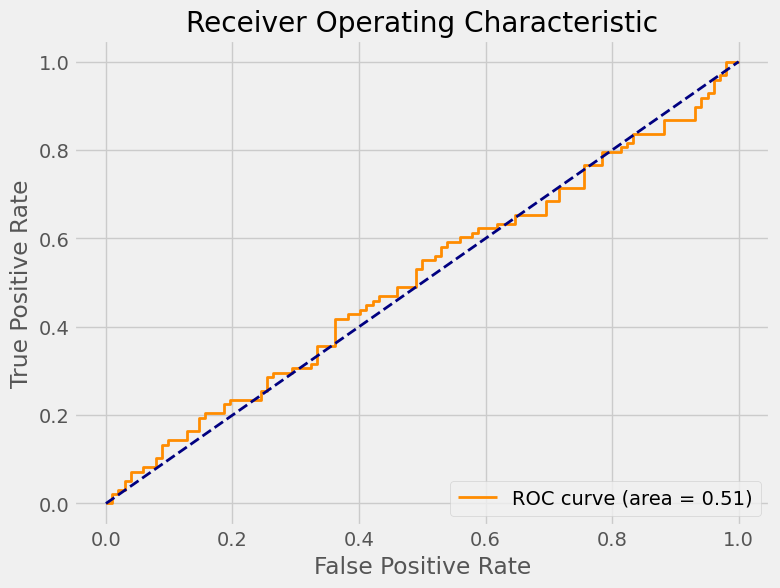

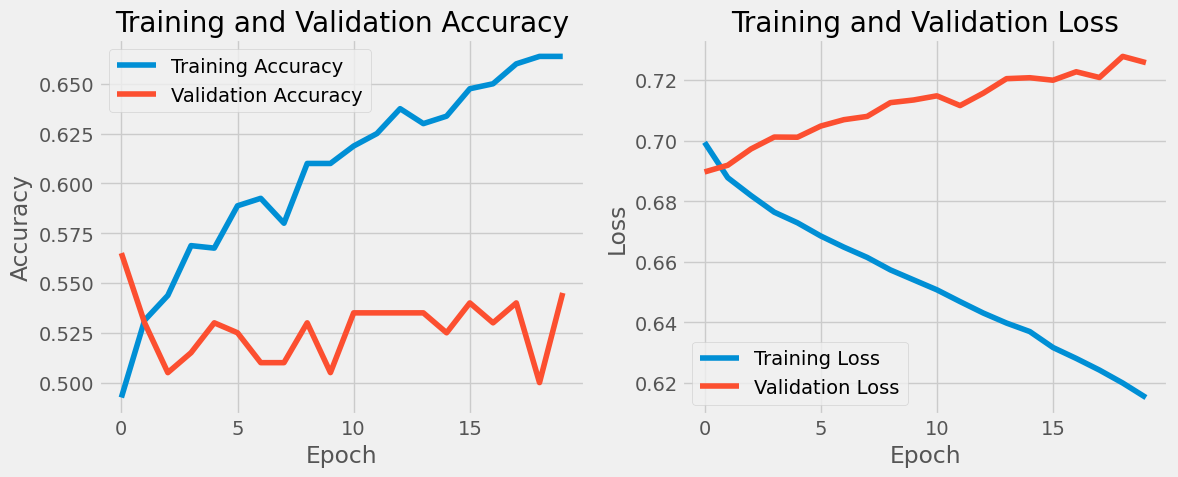

In [123]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.mixture import BayesianGaussianMixture
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Generate synthetic data for demonstration
np.random.seed(0)
n_samples = 1000
n_features = 10
XX = pd.DataFrame(np.random.randn(n_samples, n_features), columns=[f'Feature_{i}' for i in range(n_features)])
yy = pd.Series(np.random.randint(0, 2, n_samples), name='label')

# Train-Test Split
XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.2, random_state=42)

# Feature Scaling
scaler = StandardScaler()
XX_train_scaled = scaler.fit_transform(XX_train)
XX_test_scaled = scaler.transform(XX_test)

# Train Bayesian Gaussian Mixture Model on the training set
bmm = BayesianGaussianMixture(n_components=2, max_iter=100, random_state=42)
bmm.fit(XX_train_scaled[yy_train == 0])  # Assuming binary classification, fitting on normal class

# Evaluate on the test set
anomaly_scores = -bmm.score_samples(XX_test_scaled)
yy_test = yy_test.reset_index(drop=True)  # Reset index for correct matching

# Perform 10-fold cross-validation for ROC AUC
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

roc_auc_list = []
optimal_threshold_list = []

for train_index, test_index in kf.split(XX_test_scaled, yy_test):
    X_train_fold, X_test_fold = XX_test_scaled[train_index], XX_test_scaled[test_index]
    y_train_fold, y_test_fold = yy_test[train_index], yy_test[test_index]

    anomaly_scores_fold = -bmm.score_samples(X_test_fold)

    fpr, tpr, thresholds = roc_curve(y_test_fold, anomaly_scores_fold)
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

    # Find optimal threshold using Youden's Index
    Youden_Index = tpr - fpr
    optimal_threshold = thresholds[np.argmax(Youden_Index)]
    optimal_threshold_list.append(optimal_threshold)

# Calculate metrics for different thresholds
def evaluate_threshold(threshold, scores, true_labels):
    predictions = (scores > threshold).astype(int)
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    return accuracy, precision, recall, f1

# Find best threshold based on ROC AUC
best_idx = np.argmax(roc_auc_list)
best_threshold = optimal_threshold_list[best_idx]
best_auc = roc_auc_list[best_idx]

# Evaluate metrics using the best threshold
best_accuracy, best_precision, best_recall, best_f1 = evaluate_threshold(best_threshold, anomaly_scores, yy_test)

# Average optimal threshold
avg_threshold = np.mean(optimal_threshold_list)
avg_accuracy, avg_precision, avg_recall, avg_f1 = evaluate_threshold(avg_threshold, anomaly_scores, yy_test)

# Default threshold (assuming 0.5)
default_threshold = 0.5
default_accuracy, default_precision, default_recall, default_f1 = evaluate_threshold(default_threshold, anomaly_scores, yy_test)

# Print metrics
print("Metrics using Best Threshold (based on ROC AUC):")
print(f"Accuracy: {best_accuracy:.4f}, Precision: {best_precision:.4f}, Recall: {best_recall:.4f}, F1-score: {best_f1:.4f}")
print("\nMetrics using Average Optimal Threshold:")
print(f"Accuracy: {avg_accuracy:.4f}, Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}, F1-score: {avg_f1:.4f}")
print("\nMetrics using Default Threshold (0.5):")
print(f"Accuracy: {default_accuracy:.4f}, Precision: {default_precision:.4f}, Recall: {default_recall:.4f}, F1-score: {default_f1:.4f}")

# Plot ROC curve for best fold
plt.figure(figsize=(8, 6))
fpr, tpr, thresholds = roc_curve(yy_test, anomaly_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

# Neural Network for training accuracy and loss curves (example)
model = Sequential([
    Dense(64, activation='relu', input_shape=(XX_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(XX_train_scaled, yy_train, validation_data=(XX_test_scaled, yy_test), epochs=20, batch_size=32, verbose=0)

# Plot training history
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


**Dataset specifications**

In [124]:
import pandas as pd
import os

# Load datasets
train = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv")
test = pd.read_csv("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")

# Number of features per data point
num_features_per_data_point = train.shape[1] - 1  # Exclude the target column 'label'

# Number of data points (samples)
num_data_points_train = len(train)
num_data_points_test = len(test)

# Number of classes (types of attacks)
num_classes = len(train['label'].unique())

# Size of the dataset in MB or GB (assuming both train and test sets together)
dataset_size_bytes = os.path.getsize("/kaggle/input/unsw-nb15/UNSW_NB15_training-set.csv") + os.path.getsize("/kaggle/input/unsw-nb15/UNSW_NB15_testing-set.csv")
dataset_size_gb = dataset_size_bytes / (1024 * 1024 * 1024)

# Number of training, validation, and test samples
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

num_train_samples = int(train_ratio * num_data_points_train)
num_val_samples = int(val_ratio * num_data_points_train)
num_test_samples = num_data_points_test

# Parameters based on model architecture (hypothetical example)
num_layers = 3
neurons_per_layer = [256, 128, 64]  # Example of neurons per layer

# Calculate total number of parameters in the model (hypothetical example)
total_parameters = 0
for i in range(num_layers):
    if i == 0:
        # First layer with input features
        total_parameters += (num_features_per_data_point + 1) * neurons_per_layer[i]  # +1 for bias
    else:
        total_parameters += (neurons_per_layer[i-1] + 1) * neurons_per_layer[i]  # +1 for bias

# Training time estimation (hypothetical example)
training_time_per_epoch_minutes = 3
num_epochs = 50

total_training_time_hours = training_time_per_epoch_minutes * num_epochs / 60  # Total training time in hours

# Print results
print(f"Number of features per data point: {num_features_per_data_point}")
print(f"Number of data points (train): {num_data_points_train}")
print(f"Number of data points (test): {num_data_points_test}")
print(f"Number of classes: {num_classes}")
print(f"Size of the dataset: {dataset_size_gb:.2f} GB")
print(f"Number of training samples: {num_train_samples}")
print(f"Number of validation samples: {num_val_samples}")
print(f"Number of test samples: {num_test_samples}")
print(f"Number of layers in the model: {num_layers}")
print(f"Number of neurons per layer: {neurons_per_layer}")
print(f"Total number of parameters in the model: {total_parameters}")
print(f"Total training time: {total_training_time_hours:.2f} hours")


Number of features per data point: 44
Number of data points (train): 82332
Number of data points (test): 175341
Number of classes: 2
Size of the dataset: 0.04 GB
Number of training samples: 65865
Number of validation samples: 8233
Number of test samples: 175341
Number of layers in the model: 3
Number of neurons per layer: [256, 128, 64]
Total number of parameters in the model: 52672
Total training time: 2.50 hours
